# Label Quality Scores for Regression with Noisy Labels 

This quickstart tutorial shows how to use cleanlab for finding label errors in regression data. Using the approach mentioned here, you can find label error in any regression dataset irrespective of modality i.e., tabular, text, image etc. 

**This example will take you through following:**
- Generate label quality scores for each datapoint in the dataset. 
- Find label issue for regression dataset. 

Quickstart 

Cleanlab uses two inputs to generates scores for labels in the dataset:
- `labels`: NumPy array of given labels in the dataset. labels[i] should contain label for `i`-th datapoint. 
- `predictions`: NumPy array of predictions generated through your favourite regressor. predictions[i] should contain predicted value for `i`-th datapoint. 

If you already have predictions from your regressor, you can generate label quality scores for each datapoint using the code below: 

<div  class=markdown markdown="1" style="background:white;margin:16px">

```python 

from cleanlab.regression.rank import get_label_quality_scores
label_quality_scores = get_label_quality_scores(labels, predictions)

```
</div>
</div>

# 0. Visualization (can skip these details)

This is added just for reference. We will use this function to plot dataset, highlight points using label quality scores and true_errors.
You can skip this part and move to next section. 

<details><summary>See the code for visualization **(click to expand)** </summary>

```python 
# Note: this pulldown is for docs.cleanlab.ai, if running on local Jupyter or colab, please ignore it. 

def plot_data(
    data_x, data_y, circles, title, alpha=0.6, color="#1f77b4", colorbar=False, xlabel="", ylabel=""
):
    plt.figure(figsize=(14, 5))
    data_x = data_x.to_numpy()
    data_y = data_y.to_numpy()
    plt.scatter(data_x, data_y, c=color, s=30)
    for i in circles:
        plt.plot(
            data_x[i],
            data_y[i],
            "o",
            markerfacecolor="none",
            markeredgecolor="red",
            markersize=10,
            markeredgewidth=2.5,
            alpha=alpha,
        )
    plt.title(title, fontsize=20)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    if colorbar:
        plt.colorbar(orientation="vertical")

```
</details>

In [ ]:
def plot_data(
    data_x, data_y, circles, title, alpha=0.6, color="#1f77b4", colorbar=False, xlabel="", ylabel=""
):
    plt.figure(figsize=(14, 5))
    data_x = data_x.to_numpy()
    data_y = data_y.to_numpy()
    plt.scatter(data_x, data_y, c=color, s=30)
    for i in circles:
        plt.plot(
            data_x[i],
            data_y[i],
            "o",
            markerfacecolor="none",
            markeredgecolor="red",
            markersize=10,
            markeredgewidth=2.5,
            alpha=alpha,
        )
    plt.title(title, fontsize=20)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    if colorbar:
        plt.colorbar(orientation="vertical")

## 1. Install dependencies and import them 
You can use `pip` to install all packages required for this tutorial as follows:

`!pip install cleanlab xgboost`

In [ ]:
!pip install cleanlab xgboost

In [94]:
# Package installation (hidden on docs website).
# Package versions we used: xgboost==1.7.2

dependencies = ["cleanlab", "xgboost"]

if "google.colab" in str(get_ipython()):  # Check if it's running in Google Colab
    %pip install cleanlab  # for colab
    cmd = " ".join([dep for dep in dependencies if dep != "cleanlab"])
    %pip install $cmd
else:
    missing_dependencies = []
    for dependency in dependencies:
        try:
            __import__(dependency)
        except ImportError:
            missing_dependencies.append(dependency)

    if len(missing_dependencies) > 0:
        print("Missing required dependencies:")
        print(*missing_dependencies, sep=", ")
        print("\nPlease install them before running the rest of this notebook.")

In [95]:
import numpy as np
import pandas as pd
from cleanlab.regression.rank import get_label_quality_scores
import xgboost as xgb
import matplotlib.pyplot as plt

np.set_printoptions(suppress=True)

# 2. Import dataset and Generate predictions

In [107]:
path = "/Users/krmayank/Desktop/Work/cleanlab/experiments/student_score_regression.csv"
data = pd.read_csv(path, index_col=0)
data.head()

,exam_1,exam_2,exam_3,notes,true_labels,labels
0,53,77,93,NaN,76.2,76.2
1,81,64,80,great participation +10,85.5,85.5
2,74,88,97,NaN,87.4,87.4
3,61,94,78,NaN,77.7,77.7
4,48,90,91,NaN,77.8,77.8


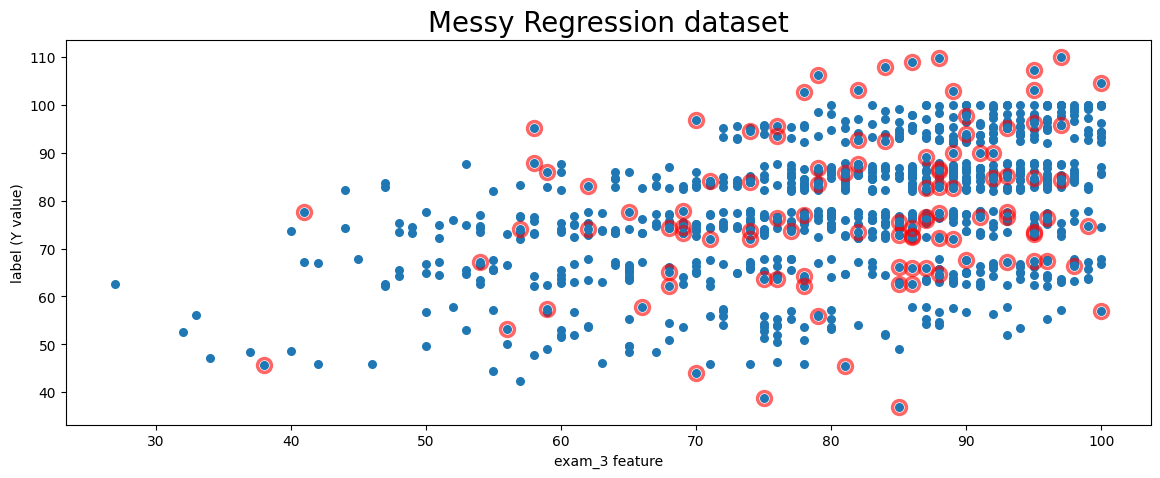

In [108]:
# Generate true errors
true_errors = np.where(data.labels != data.true_labels)[0]
plot_data(
    data_x=data["exam_3"],
    data_y=data["labels"],
    circles=true_errors,
    title="Messy Regression dataset",
    xlabel="exam_3 feature",
    ylabel="label (Y value)",
)

In the dataframe displayed above, `labels` represents the noisy labels and `true_labels` represents the ground truth. Please note that, ground truth are usually not available in real dataset, we have added it here for comparision and to demonstrate our method. `notes` also has text information, we will model this a categorical variable. 

We will use `xgboost` as regressor for this tutorial. xgboost provides easy to use interface to process categorical variable. This is demonstrated in the code below:

In [109]:
# XGBOOST automatically factors categorical variable, you just need to mark the columns as category
data.notes = data.notes.astype("category")

# XGBOOST takes data and label seperately, so you will need to divide data accordingly.
X = data.drop(["labels", "true_labels"], axis=1)
y = data["labels"]

# convert data to format "DMatrix" to make it compatible with XGBOOST.
xgboost_data = xgb.DMatrix(data=X, label=y, enable_categorical=True)

# declare parameters and train the model.
params = {"booster": "gblinear", "objective": "reg:squarederror"}
boost = xgb.train(params=params, dtrain=xgboost_data, num_boost_round=50)

## 3. Using cleanlab to generate label quality scores

In [110]:
# using trained xgboost model to get predictions
predictions = boost.predict(xgboost_data)

# get label quality score for each example in the dataset using cleanlab
label_quality_scores = get_label_quality_scores(labels=np.array(y), predictions=predictions)

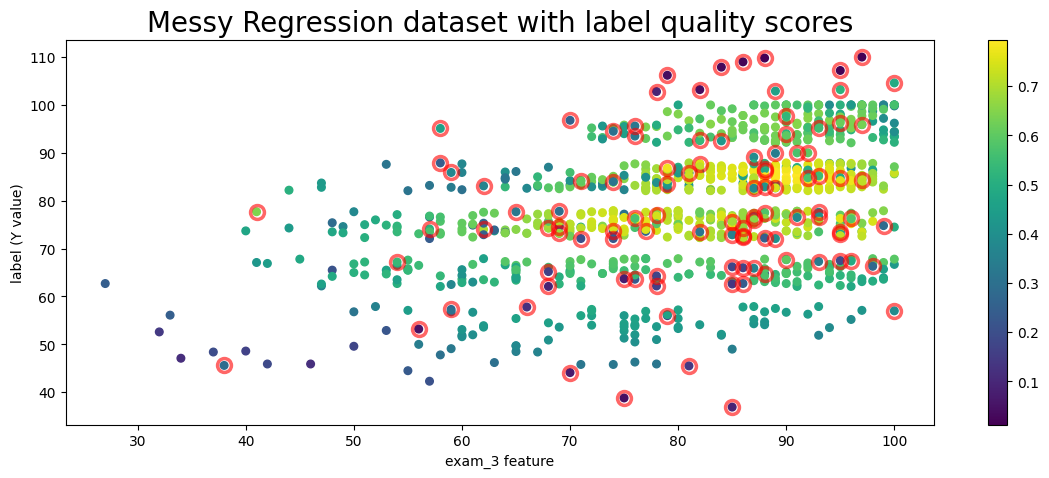

In [111]:
plot_data(
    data_x=data["exam_3"],
    data_y=data["labels"],
    circles=true_errors,
    color=label_quality_scores,
    title="Messy Regression dataset with label quality scores",
    colorbar=True,
    xlabel="exam_3 feature",
    ylabel="label (Y value)",
)

In the above plot, we have colored each datapoint considering its label quality score. \
Datapoints in the plot are same as earlier plot in the notebook. \
**Red circle** represents that these datapoint were incorrectly marked when compared to true_label. 

Low scores for datapoints marked in **Red circle** and High scores for other datapoints justifies that method can identify the errors in the dataset. 

In [112]:
# Note: This cell is only for docs.cleanlab.ai, if running on local Jupyter or Colab, please ignore it.
from sklearn.metrics import roc_auc_score

label_quality_scores = get_label_quality_scores(np.array(y), predictions=predictions)

true_errors = (data.labels != data.true_labels).astype(int)
label_quality_scores_residual = get_label_quality_scores(
    np.array(y), predictions=predictions, method="residual"
)

if roc_auc_score(true_errors, 1 - label_quality_scores) < 0.5:
    raise ValueError("Label quality scores did not perform well enough")

if roc_auc_score(true_errors, 1 - label_quality_scores) <= roc_auc_score(
    true_errors, 1 - label_quality_scores_residual
):
    raise ValueError("Label quality scores did not outperform alternative scores")